In [1]:
import torch
import torch.nn as nn
import torch.onnx
from torchinfo import summary


## simp network

* Input shape is [batch, channels=1, height=28, width=28]

* Output shape will be [batch, 4, 28, 28] (due to 4 output channels, padding=1)

In [2]:
# Define a simple model with 1 convolutional layer
class demoModel1(nn.Module):
    def __init__(self):
        super(demoModel1, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        return self.conv(x)

# Instantiate and set to eval mode
model = demoModel1()

In [3]:
model.eval()

demoModel1(
  (conv): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [4]:
summary(model, (1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
demoModel1                               [1, 4, 28, 28]            --
├─Conv2d: 1-1                            [1, 4, 28, 28]            40
Total params: 40
Trainable params: 40
Non-trainable params: 0
Total mult-adds (M): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.03

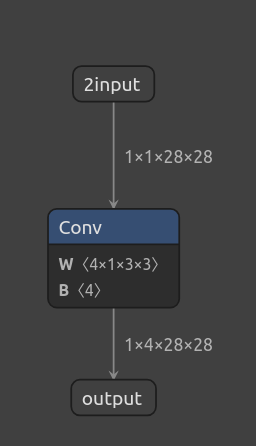

In [5]:
# Dummy input for export (e.g., 1 sample, 1 channel, 28x28 image)
dummy_input = torch.randn(1, 1, 28, 28)

# Export to ONNX
torch.onnx.export(
    model,
    dummy_input,
    "demoModel1.onnx",
    input_names=["2input"],
    output_names=["output"],
    opset_version=19 
)

In [6]:
!ls -lah demoModel1.onnx

-rw-rw-r-- 1 vlad vlad 468 Jun 10 11:21 demoModel1.onnx


## convert1

* run for 3588 

```
~/shared/genConverts$ python convert.py demoModel1.onnx  rk3588 fp  demoModel1.rknn
W __init__: rknn-toolkit2 version: 1.6.0+81f21f4d
[1/4] config()
[2/4] load_onnx() demoModel1.onnx
Loading : 100%|████████████████████████████████████████████████████| 2/2 [00:00<00:00, 27235.74it/s]
[3/4] build() FP32
[4/4] export_rknn() demoModel1.rknn
✔ Done – RKNN saved at: demoModel1.rknn

```

## convert2

The RV1106 NPU only supports quantized models ; need calibration dataset file (dataset.txt)


run that on the host machine to generate the calibration dataset file and images

``` bash
### pip install Pillow
import os
from PIL import Image

NUM_OF_CALS = 5

# Create calibration image directory
os.makedirs("calib_images", exist_ok=True)

# Generate 20 grayscale images of 28x28 pixels (constant gray)
for i in range(NUM_OF_CALS):
    img = Image.new("L", (28, 28), color=128)  # "L" = grayscale mode
    img_path = f"calib_images/img{i}.png"
    img.save(img_path)

# Write full paths to dataset.txt
with open("dataset.txt", "w") as f:
    for i in range(NUM_OF_CALS):
        abs_path = os.path.abspath(f"calib_images/img{i}.png")
        f.write(f"{abs_path}\n")

print(f"✔ Created {NUM_OF_CALS} images and dataset.txt")
```

*  run for 1106

```
> python convert.py demoModel1.onnx  rv1106 i8  demoModel1.rknn
W __init__: rknn-toolkit2 version: 1.6.0+81f21f4d
[1/4] config()
[2/4] load_onnx() demoModel1.onnx
Loading : 100%|████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26973.02it/s]
[3/4] build() with quant
GraphPreparing : 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00, 5384.22it/s]
Quantizating : 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00, 54.82it/s]
W build: The default input dtype of '2input' is changed from 'float32' to 'int8' in rknn model for performance!
                       Please take care of this change when deploy rknn model with Runtime API!
W build: The default output dtype of 'output' is changed from 'float32' to 'int8' in rknn model for performance!
                      Please take care of this change when deploy rknn model with Runtime API!
[4/4] export_rknn() demoModel1.rknn
✔ Done – RKNN saved at: demoModel1.rknn


```